In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import pickle
import matplotlib.pyplot as plt
from ipywidgets import interactive

Загрузим данные и преобразуем также, как и в 1 части дз

In [ ]:
df_scores = pd.read_csv('/content/gdrive/My Drive/data_scores_and_features.csv')

x_scores = pd.read_csv('/content/gdrive/My Drive/data_scores.csv', sep=';', decimal=',')
                                       
data_vintages_1 = pd.read_csv('/content/gdrive/My Drive/vintages_1.csv')

data_vintages_2 = pd.read_csv('/content/gdrive/My Drive/vintages_2.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
data_vintages = pd.concat([data_vintages_1, data_vintages_2])

data_vintages.dropna(subset=['user_id'])

data_vintages = data_vintages.drop([1246634])

data_vintages['statement_num'] = data_vintages['statement_num'].apply(lambda x : int(x))

df_scores = df_scores.drop([32506, 68471, 93755])

Загрузим модель и обработаем признаки 

In [ ]:
filename = '/content/gdrive/My Drive/model.sav'
model = pickle.load(open(filename, 'rb'))

features = [
            'max_util',
            'soc_dem_score',
            'other_util',
            'last_credit_time_years',
            'credits_4y',
            'avg_limit_mortgage',
            'min_limit_mfo',
            'close_balance_amt',
            'avg_active_time',
]

df_scores['avg_active_time'] = df_scores['avg_active_time'].fillna(df_scores['avg_active_time'].median())
df_scores['avg_limit_mortgage'] = -df_scores['avg_limit_mortgage']
df_scores['close_balance_amt'] = -df_scores['close_balance_amt']
df_scores['max_util'] = df_scores['max_util'].clip(upper=2)

df_scores['model_pd'] = model.predict_proba(df_scores[features])[:,1]

Объединим винтажи, x_score из x_scores и pd из df_scores в один датафрейм, а также добавим бакеты для x_score и pd

In [ ]:
df_scores = df_scores.sort_values(['model_pd'], ignore_index=True)
df_scores['pd_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['pd_bucket'])['model_pd'].mean())

x_scores = x_scores.sort_values(['x_score'], ignore_index=True)
x_scores['x_bucket'] = np.minimum(x_scores.index // (df_scores.shape[0]//3),2)
print(x_scores.groupby(['x_bucket'])['x_score'].mean())

pd_bucket
0    0.026104
1    0.048586
2    0.096909
Name: model_pd, dtype: float32
x_bucket
0    0.133269
1    0.220834
2    0.379446
Name: x_score, dtype: float64


In [ ]:
data_vintages = data_vintages.merge(df_scores[['user_id', 'pd_bucket', 'model_pd']], how='left', on='user_id', suffixes=None).dropna()
data_vintages = data_vintages.merge(x_scores[['user_id', 'x_bucket', 'x_score']], how='left', on='user_id', suffixes=None).dropna()
data_vintages

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' as a <class 'NoneType'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  validate=validate,


,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg,pd_bucket,model_pd,x_bucket,x_score
0,127336.0,19,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0,2.0,0.068919,2,0.469410
1,35907.0,16,2019-04-01,2019-04-01,1,0,0,0,1,0.0,0.0,0.0,1.0,0.062210,0,0.157215
2,45228.0,21,2019-05-01,2019-04-01,0,0,0,1,0,0.0,0.0,1.0,1.0,0.061996,2,0.469583
3,39035.0,23,2019-07-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0,0.0,0.028807,1,0.210896
4,130780.0,19,2019-08-01,2019-07-01,1,0,0,0,1,0.0,0.0,0.0,1.0,0.046344,1,0.269492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2538627,64006.0,19,2019-05-01,2019-04-01,1,0,0,0,0,0.0,1.0,1.0,1.0,0.060381,1,0.188233
2538628,138666.0,21,2019-09-01,2019-07-01,1,0,0,0,0,0.0,0.0,1.0,0.0,0.023367,1,0.221981
2538629,120568.0,1,2019-08-01,2019-07-01,0,0,0,1,0,0.0,0.0,1.0,1.0,0.042375,0,0.104274
2538630,191861.0,6,2020-01-01,2020-01-01,0,0,0,1,0,0.0,0.0,1.0,1.0,0.047337,0,0.172479


## СLO ratio

In [ ]:
clo_ratio_data = (data_vintages.groupby(["gen_quarter_dt", "statement_num"])    
        .agg({"clo_flg":np.mean})                                         
        .rename(columns = {"clo_flg": 'clo_ratio'})                   
        .unstack('gen_quarter_dt'))                                       
clo_ratio_data

Построим винтажи кривой CLO ratio

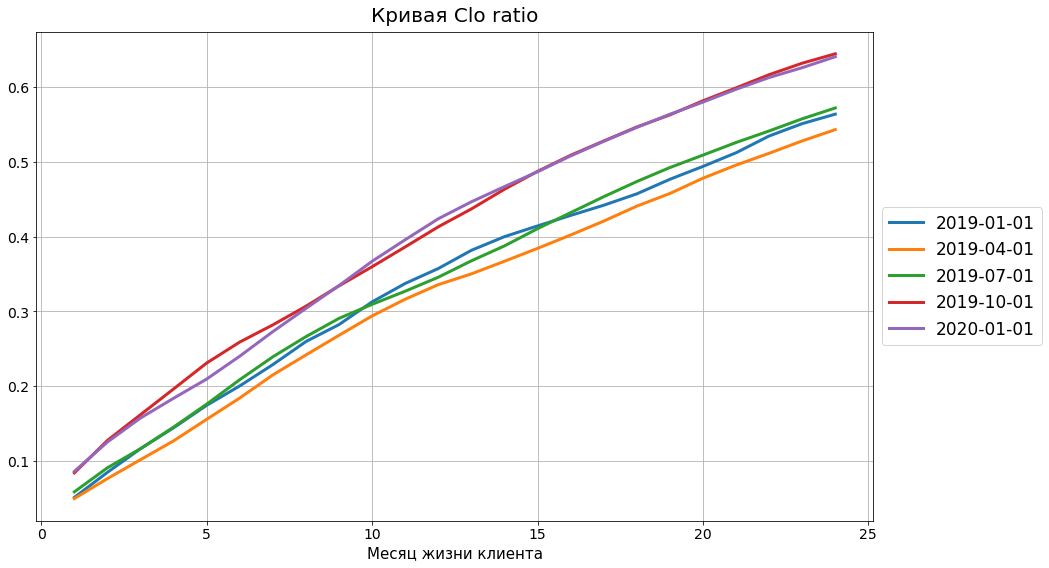

In [ ]:
def plot_clo_ratio_by_generation():
    return (data_vintages.groupby(["gen_quarter_dt", "statement_num"])
              .agg({"clo_flg":np.mean})
              .rename(columns = {"clo_flg": 'clo_ratio'})
              .unstack('gen_quarter_dt')
              ['clo_ratio']
              .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))               

# Строим график при помощи pyplot
plot_clo_ratio_by_generation()

# Настраиваем параметры отображения графика
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Clo ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Разделение кривых по PD


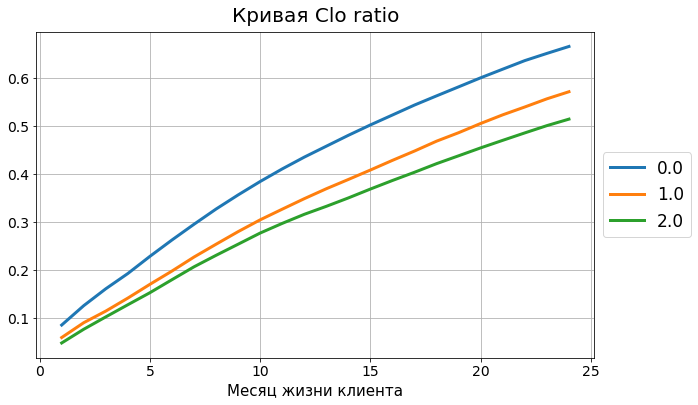

In [ ]:
def plot_default_ratio_by_bucket(df, bucket):
    return (data_vintages.groupby([bucket, "statement_num"])
            .agg({"clo_flg":np.mean})
            .rename(columns = {"clo_flg": 'clo_ratio'})
            .unstack(bucket)
            ['clo_ratio']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

plot_default_ratio_by_bucket(data_vintages, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Clo ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Разделение кривых по x_score


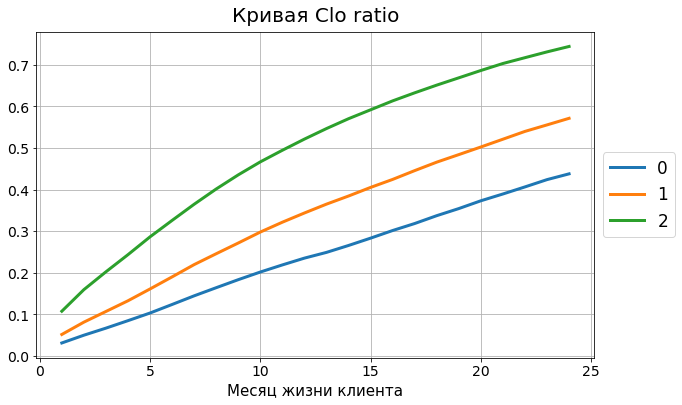

In [ ]:
plot_default_ratio_by_bucket(data_vintages, 'x_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Clo ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Из графиков очевидно, что x_score лучше разделяет кривые, для разбиения по pd 1 и 2 бакет плохо различимы + при разбиении по x_score кривые имеют более различающиеся точки перегиба, что, возможно, также полезно для анализа, выбираем x_score.

Отрисуем распределение данных во времени в разбивке по x_score.

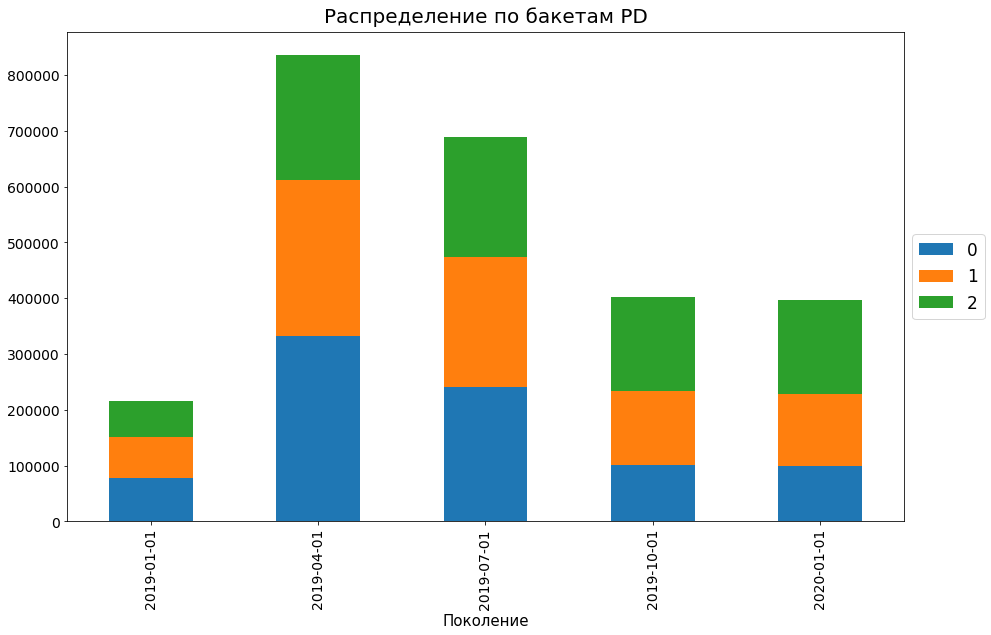

In [ ]:
def plot_distribution(df, bucket):
    return pd.pivot_table(data_vintages, index=[bucket], columns='gen_quarter_dt',          
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                   

plot_distribution(data_vintages, 'x_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам PD", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Из графика видно, что для поколений, соответствуюшим весеннему и летнему кварталам, наблюдений на порядок больше и вспоминая, что мы имеем дело с кредитом на 2 года, предполагаем, что он на большую сумму, тогда закономерность на визуализации можно объяснить некоторыми сезонными обстоятельствами, например, люди весной и летом активнее берут деньги для строительства жилья.

Как и в ситуации на семинаре, для поколения января 2019 года наблюдений сильно меньше, но всё равно достаточно много и они сбалансированны по бакетам, так что ничего выбрасывать не будем.

## CLO rate

Реализуем функцию, которая отрисовывает винтажи CLO rate в разбивке по бакетам для x_score

In [ ]:
%matplotlib inline
# Выгружаем таблицу c винтажами

clo_rate_data_x = data_vintages.eval('clo_new_flg = clo_flg * prev_act_flg', inplace=False)\
    .groupby(["gen_quarter_dt", 'x_bucket', "statement_num"])\
    .agg({"clo_new_flg":np.sum, "prev_act_flg":np.sum, "user_id":np.count_nonzero})\
    .rename(columns = ({"clo_new_flg":'clo_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
    .eval('clo_rate = clo_cnt / prev_act_cnt', inplace=False)

buckets_x = data_vintages['x_bucket'].drop_duplicates().sort_values(ascending = True)

def plot_clo_rate_by_generation(bucket):
    
    cur_df = clo_rate_data_x.query('x_bucket == ' + str(bucket))
    (cur_df.unstack('gen_quarter_dt')
            ['clo_rate']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая CLO rate, bucket = " + str(bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

Построим винтажи

In [ ]:
vintages_graph = interactive(plot_clo_rate_by_generation, bucket = buckets_x)
vintages_graph

interactive(children=(Dropdown(description='bucket', options=(0, 1, 2), value=0), Output()), _dom_classes=('wi…

Cамой характерной точкой независимо от бакета и поколения является первый месяц жизни клиента, на неё приходится сильный пик роста, что можно объяснить тем, что достаточно большое число клиентов передумывает реализовывать те задачи, под которые они брали кредит, и возвращают деньги обратно.

Также относительно интересными точками, которые можно проинтепретировать, являются 22-23 месяцы жизни кредита, на которые также приходятся пики роста закрытия счетов. Я думаю, это связано с тем, что довольно много клиентов, которым осталось внести буквально пару взносов, хотят быстрее избавиться от долговой нагрузки, поэтому стараются закрывать остатки одним платежом.

Мне кажется, эти точки не стоит исключать, так как они закладывают важные тенденции в кривые.

Среди поколений выделим то, которое относится к января 2019 года, оно ведёт себя наиболее непредсказуемо для всех бакетов, с большой амплитудой сменяя участки роста и падения, поэтому исключим его из дальнейшего рассмотрения.

Также из 0 и 1 бакета я решил исключить поколение апреля 2019, так как оно имеет сильную, нехарактерную для других поколений просадку примерно с 12 по 18 месяц.

### Построим среднее по винтажам для каждого бакета

In [ ]:
# Исключаем "странные" поколения

exception_query_0 = ''' ~((gen_quarter_dt == '2019-01-01') & (x_bucket == 0)) '''
exception_query_1 = ''' ~((gen_quarter_dt == '2019-01-01') & (x_bucket == 1)) '''
exception_query_2 = ''' ~((gen_quarter_dt == '2019-01-01') & (x_bucket == 2)) '''
exception_query_3 = ''' ~((gen_quarter_dt == '2019-04-01') & (x_bucket == 0)) '''
exception_query_4 = ''' ~((gen_quarter_dt == '2019-04-01') & (x_bucket == 1)) '''


clo_rate_data_x.query(exception_query_0, inplace = True)
clo_rate_data_x.query(exception_query_1, inplace = True)
clo_rate_data_x.query(exception_query_2, inplace = True)
clo_rate_data_x.query(exception_query_3, inplace = True)
clo_rate_data_x.query(exception_query_4, inplace = True)

# Считаем среднее

clo_rate_mean = clo_rate_data_x.groupby(['statement_num', 'x_bucket'])\
    .agg({'clo_rate':np.mean})\
    .rename(columns = {'clo_rate':'Среднее'})

# Строим графики винтажей и среднего

def plot_clo_rate_mean(x_bucket):
    vintages_graph = clo_rate_data_x.query('x_bucket == ' + str(x_bucket))\
            .unstack('gen_quarter_dt')\
            ['clo_rate']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (clo_rate_mean.query('x_bucket == ' + str(x_bucket))
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Clo rate, bucket = " + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

vintages_graph = interactive(plot_clo_rate_mean, x_bucket = buckets_x)
vintages_graph

interactive(children=(Dropdown(description='x_bucket', options=(0, 1, 2), value=0), Output()), _dom_classes=('…

### Опробуем различные способы сглаживания средних кривых 

Не будем сглаживать точки для 1 месяца и всех месяцев, начиная с 22, так как хотим сохранить особенности, озвученные выше.

Выбирать будем на 0 бакете, наиболее подходящий подход применим к двум оставшимся.

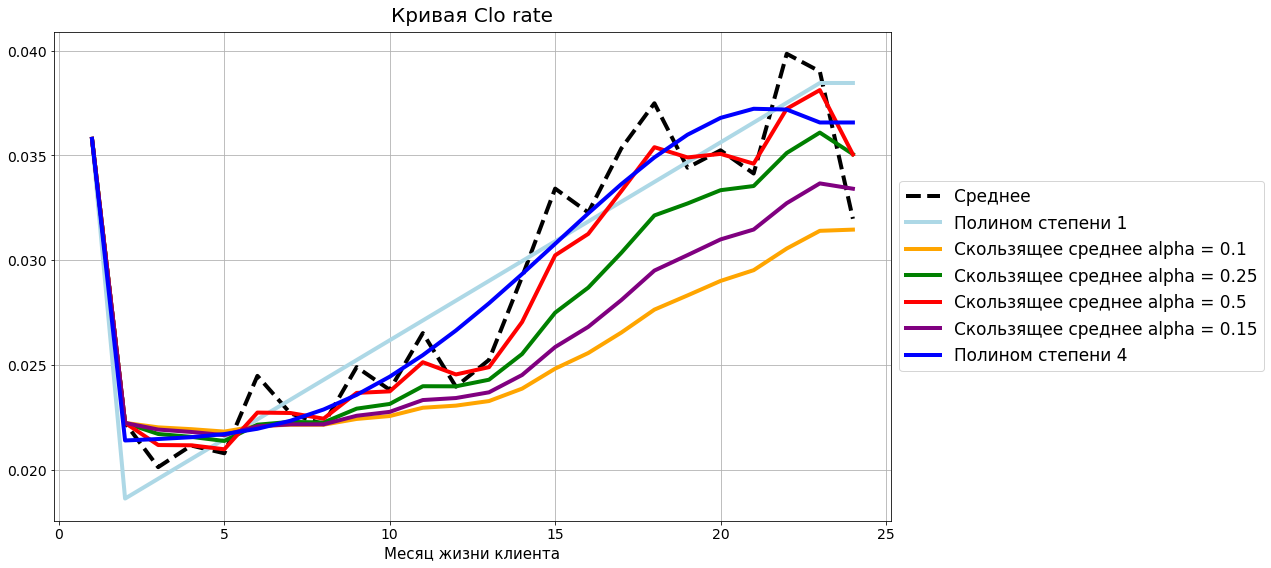

In [ ]:
def linear_approximation(df, start=1, finish=24):
    df_res = pd.DataFrame(df)
    df_res['Линейная функция'] = df['Среднее']                                                # Копируем средние значения
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], 1)  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)                                                    # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, 'Линейная функция'] = linear_coeff(np.arange(start, finish+1))   # Записываем приближение
    df_res.loc[finish+1:, 'Линейная функция'] = linear_coeff(finish+1)                        # Продолжаем кривую константой
    return df_res

def polynom_approximation(df, start=1, finish=24, degree = 1, bucket=-1):
    df_res = pd.DataFrame(df)
    if bucket < 0:
      df_res[f'Полином степени {degree}'] = df['Среднее']   
    else:
      df_res[f'Полином степени {degree} для бакета {bucket}'] = df['Среднее']                   
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)           
    if bucket < 0:                                      
      df_res.loc[start:finish, f'Полином степени {degree}'] = linear_coeff(np.arange(start, finish+1)) 
      df_res.loc[finish+1:, f'Полином степени {degree}'] = linear_coeff(finish+1)   
    else:
      df_res.loc[start:finish, f'Полином степени {degree} для бакета {bucket}'] = linear_coeff(np.arange(start, finish+1)) 
      df_res.loc[finish+1:, f'Полином степени {degree} для бакета {bucket}'] = linear_coeff(finish+1)                   
    return df_res

def exponential_smoothing(df, start=1, finish=24, alpha=0.25):
    df_res = pd.DataFrame(df)
    result = [df_res.loc[i,'Среднее'] for i in np.arange(1,start+1)]                              # Начальные значения копируем
    for n in range(start, len(df_res['Среднее'])): 
        result.append(float(alpha * df_res.loc[n + 1, 'Среднее'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res[f'Скользящее среднее alpha = {alpha}'] = result
    return df_res

# Делаем аппроксимацию

df_linear = clo_rate_mean.query('x_bucket == 0').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 2, 22)
df_polynom_1 = polynom_approximation(df_linear, 2, 22, 1)
df_polynom_2 = polynom_approximation(df_polynom_1, 2, 22, 4)
df_smooth_1 = exponential_smoothing(df_polynom_2, 2, 22, 0.1)
df_smooth_2 = exponential_smoothing(df_smooth_1, 2, 22)
df_smooth_3 = exponential_smoothing(df_smooth_2, 2, 22, 0.5)
df_smooth_4 = exponential_smoothing(df_smooth_3, 2, 22, 0.15)


# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth_4['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth_4['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth_4['Полином степени 1'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth_4['Скользящее среднее alpha = 0.1'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)
df_smooth_4['Скользящее среднее alpha = 0.25'].plot(grid=True, color = 'Green', linestyle = '-', lw = 4)
df_smooth_4['Скользящее среднее alpha = 0.5'].plot(grid=True, color = 'Red', linestyle = '-', lw = 4)
df_smooth_4['Скользящее среднее alpha = 0.15'].plot(grid=True, color = 'Purple', linestyle = '-', lw = 4)
df_smooth_4['Полином степени 4'].plot(grid=True, color = 'Blue', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Наиболее подходящей функцией для сглаживания мне показался полином степени 4. В отличие от скользящих средних он не просидает так сильно по сравнению со средним, а также не подстраивается под незначительные колебания. Сравнивая с полиномом степени 1 и линейной функцией, он гораздо лучше аппроксимирует тенденции роста и падения.

### Отрисуем сглаженные кривые по всем 3 бакетам

In [ ]:
clo_rate_bucket_0 = clo_rate_mean.query('x_bucket == 0').reset_index().set_index(['statement_num'])
clo_rate_bucket_1 = clo_rate_mean.query('x_bucket == 1').reset_index().set_index(['statement_num'])
clo_rate_bucket_2 = clo_rate_mean.query('x_bucket == 2').reset_index().set_index(['statement_num'])

df_polynom_0 = polynom_approximation(clo_rate_bucket_0, 2, 22, 4, 0)
df_polynom_1 = polynom_approximation(clo_rate_bucket_1, 2, 22, 4, 1)
df_polynom_2 = polynom_approximation(clo_rate_bucket_2, 2, 22, 4, 2)

df_polynom = pd.DataFrame()
df_polynom['0'] = df_polynom_0['Полином степени 4 для бакета 0']
df_polynom['1'] = df_polynom_1['Полином степени 4 для бакета 1']
df_polynom['2'] = df_polynom_2['Полином степени 4 для бакета 2']

In [ ]:
def smooth_clo_curves(bucket): 
  plt.figure(figsize=(15, 9))
  df_polynom[str(bucket)].plot(grid=True, color = 'Blue', linestyle = '-', lw = 4)
  plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
  plt.title("Кривая Clo rate", size=20, verticalalignment='bottom')
  plt.xlabel("Месяц жизни клиента", size=15)
  plt.tick_params(axis='both', which='major', labelsize=14)

vintages_graph = interactive(smooth_clo_curves, bucket = buckets_x)
vintages_graph

interactive(children=(Dropdown(description='bucket', options=(0, 1, 2), value=0), Output()), _dom_classes=('wi…